In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

#### choose correct comparison groups

In [2]:
comparison_X = 'ATB_v_OD'

import packages

In [3]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec
import matplotlib.pylab as pl
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

import fastcluster
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as hier

import networkx as nx
import networkx.algorithms.community as nxcom
import community
from collections import Counter
import pickle
from collections import defaultdict

import gseapy as gp
import warnings
warnings.filterwarnings('ignore')

#### set parameters for plotting

In [4]:
plt.style.use('ggplot')
plt.rcParams['lines.linewidth']=1.0
plt.rcParams['axes.facecolor']='1.0'
plt.rcParams['xtick.color']='black'
plt.rcParams['axes.grid']=False
plt.rcParams['axes.edgecolor']='black'
plt.rcParams['grid.color']= '1.0'
plt.rcParams.update({'font.size': 14})

#### specify directory paths

In [5]:
# use these paths for O2 computing cluster

#specify directory for Data
Data_files_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/'

#specify directory for pickling objects
pickled_objects_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Pickled Files/'

#specify directory for CSV files
CSV_files_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/CSV Files/'

#specify directory for Gene Set Files
Gene_Set_dir = '/n/data1/hms/dbmi/farhat/Roger/gatesMRI/Projects/Biomarkers/Data/Gene Set Files/CSV files/'

# [1] Load Data

### Network

In [6]:
G = nx.read_gpickle(pickled_objects_dir + f'Network Files/networks/{comparison_X}.pkl')

In [7]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 67
Number of edges: 326
Average degree:   9.7313


In [8]:
num_nodes_overall_network = int(len(G.nodes()))

### Weighted Degrees for Nodes (genes)

In [9]:
weighted_deg_series = pd.read_pickle(pickled_objects_dir + f'Network Files/weighted degree series/{comparison_X}.pkl')

In [10]:
np.shape(weighted_deg_series)

(67,)

### Mean $log_2(Fold Change)$ for Nodes (genes)

In [11]:
mean_logFC_series = pd.read_pickle(pickled_objects_dir + f'Network Files/mean logFC network nodes series/{comparison_X}.pkl')

In [12]:
np.shape(mean_logFC_series)

(67,)

### Compile into DataFrame

In [13]:
G_deg_logFC_df = pd.DataFrame(index = mean_logFC_series.index)
G_deg_logFC_df['mean_log2FC'] = mean_logFC_series.values
G_deg_logFC_df['weighted_degree'] = weighted_deg_series[mean_logFC_series.index].values

In [14]:
G_deg_logFC_df.head()

,mean_log2FC,weighted_degree
SEPT4,0.889510,5.7
ANKRD22,0.828368,6.1
C1QB,0.827058,5.4
BATF2,0.751017,9.4
SERPING1,0.732517,7.3


# [2] Get sub-network constructed from retaining only nodes with $mean(logFC) \ge 0.5$ & detect communities

## [2.1] Get most heavily weighted edges that pass optimal threshold & construct sub-graph

In [15]:
len(G_deg_logFC_df.mean_log2FC[abs(G_deg_logFC_df.mean_log2FC) >= 0.5].index)

12

In [16]:
#get the nodes in the network that pass the logFC threshold
nodes_high_abs_logFC_subset = list(G_deg_logFC_df.mean_log2FC[abs(G_deg_logFC_df.mean_log2FC) >= 0.5].index)

#get the SUBGRAPH induced by the most these nodes (correspond to genes with >> |logFC|)
S = G.subgraph(nodes_high_abs_logFC_subset)

In [17]:
print(nx.info(S))

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 56
Average degree:   9.3333


Use **Spring Layout** to set the positions of the nodes

In [63]:
pos = nx.spring_layout(S , weight = 'weight' , iterations = 350 , k = 0.05)

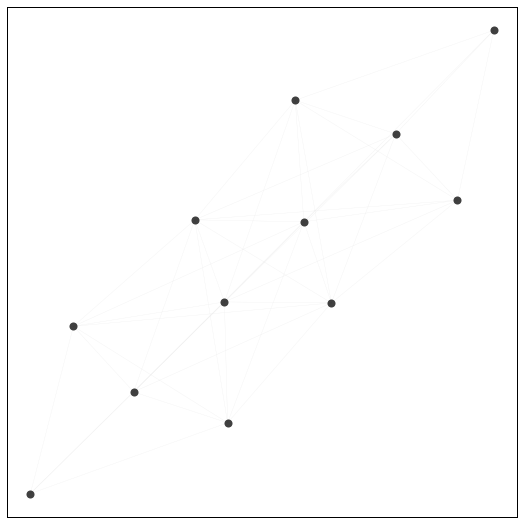

In [65]:
fig , ax = plt.subplots()

nx.draw_networkx(
    S, 
    pos = pos, 
    ax = ax,
    node_size = 65, 
    node_color = 'xkcd:black',
    linewidths = 0.0,
    edge_color = "0.9",
    width=0.25,
    alpha = 0.75, 
    with_labels = False)

fig = plt.gcf()
fig.set_size_inches(7.5, 7.5)
fig.tight_layout()
plt.show()

#### *Function* to retrieve node colors based of node values (i.e. weighted degree, logFC for gene)

In [29]:
def get_node_colors(node_values):
    
    '''
    This function takes a list of values for each node and color map, 
    normalizes the list of values from 0.0-1.0 and assigns each node 
    a color from a color map based on normalized values. Returns a 
    list of colors for nodes.
    '''
    
    #load mpl colormap and normalize to data
    color_scheme = plt.get_cmap('afmhot_r')
    norm = mpl.colors.Normalize(vmin = min(node_values), vmax = max(node_values)) #get the normalization
    color_scheme_norm = mpl.cm.ScalarMappable(norm = norm, cmap = color_scheme) #normalize the color map to the min/max values of the node values
    
    #get color for each node from color map
    color_map = []
    for node_value in node_values:
        color_map.append(color_scheme_norm.to_rgba(node_value))
        
    return [color_map, norm, color_scheme]

#### *Function* to visualize network by weighted degree & logFC based on gene values

In [66]:
def visualize_network_color_by_weighted_deg_and_logFC(G, pos):
    
    #weighted degree for nodes in this network
    node_weighted_deg_values = G_deg_logFC_df.weighted_degree[list(G.nodes)] 
    
    #logFC for nodes in this network
    node_logFC_values = G_deg_logFC_df.mean_log2FC[list(G.nodes)] 
    
    fig = plt.figure(constrained_layout=True)

    gs = GridSpec(2, 2, figure=fig, height_ratios = [13,1])

    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    
    #color nodes by weighted deg 
    node_colors , color_bar_norm , color_scheme = get_node_colors(node_weighted_deg_values)
    nx.draw_networkx(
        G, 
        pos = pos, 
        ax = ax1,
        node_size = 65, 
        node_color = node_colors,
        linewidths = 0.2, #width of the node outlines
        edge_color = "0.83",
        width=0.1,
        alpha = 1.0, 
        with_labels = False)
    ax1.collections[0].set_edgecolor("black") #color of the node outlines
    cb1 = mpl.colorbar.ColorbarBase(ax3, cmap = color_scheme, norm = color_bar_norm, orientation='horizontal')
    cb1.set_label('Weighted Degree', fontsize = 14, color = 'k', weight = 'bold')
    
    #color nodes by logFC
    node_colors , color_bar_norm , color_scheme = get_node_colors(node_logFC_values)
    nx.draw_networkx(
        G, 
        pos = pos, 
        ax = ax2,
        node_size = 65, 
        node_color = node_colors,
        linewidths = 0.2,
        edge_color = "0.83",
        width=0.1,
        alpha = 1.0, 
        with_labels = False)
    ax2.collections[0].set_edgecolor("black") #color of the node outlines
    cb2 = mpl.colorbar.ColorbarBase(ax4, cmap = color_scheme, norm = color_bar_norm, orientation='horizontal')
    cb2.set_label('Mean logFC', fontsize = 14, color = 'k', weight = 'bold')

    ################### Plot
    fig = plt.gcf()
    fig.set_size_inches(17.25, 9.0)
    fig.tight_layout()

    #file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
    #plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

    plt.show()

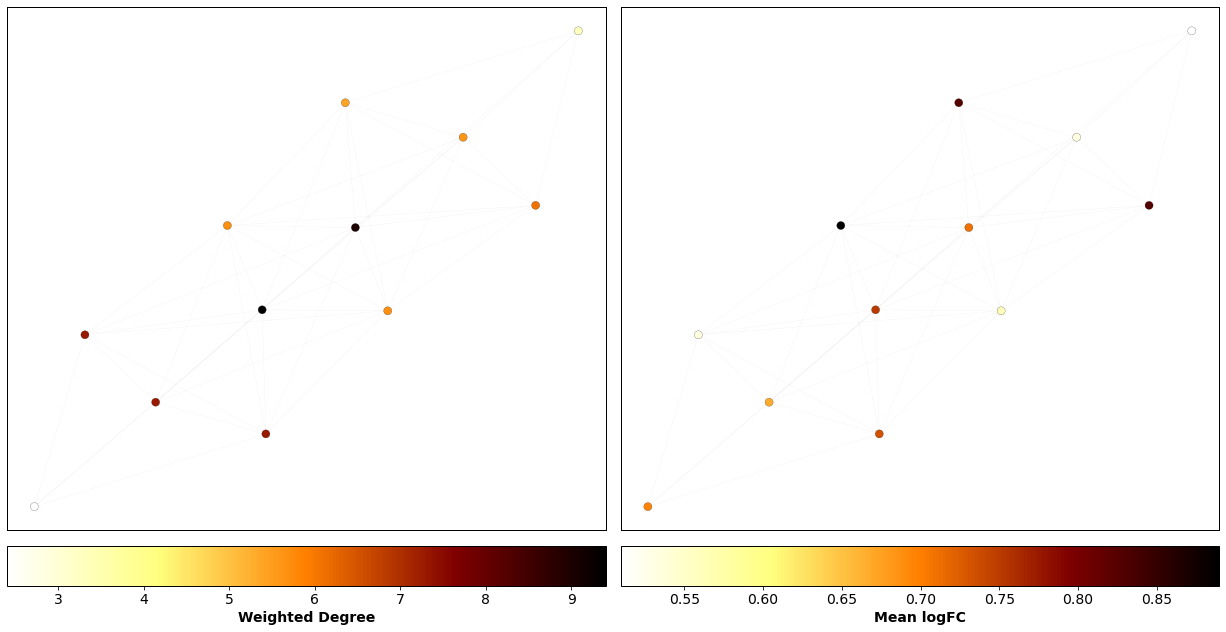

In [67]:
visualize_network_color_by_weighted_deg_and_logFC(S, pos)

## [2.2] Run gene-enrichment analysis on genes within subnetwork

### Load and prepare gene sets

DataFrame for the Gene Sets (excel files from Wen-Han)

In [32]:
GeneSets_df = pd.read_csv(f'{Gene_Set_dir}GeneModule.csv')

#subset to the IMMUNE modules
GeneSets_IMMUNE_df = GeneSets_df.loc[0:297, :]

#subset to the REACTOME modules
GeneSets_REACTOME_df = GeneSets_df.loc[993:1666, :]

In [33]:
GeneSets_IMMUNE_df.head()

,ID,Title,Category,B
0,LI.M0,targets of FOSL1/2,TF targets,12
1,LI.M1.0,integrin cell surface interactions (I),molecular function,29
2,LI.M1.1,integrin cell surface interactions (II),molecular function,12
3,LI.M2.0,extracellular matrix (I),location,30
4,LI.M2.1,extracellular matrix (II),location,45


In [34]:
np.shape(GeneSets_IMMUNE_df)

(298, 4)

In [35]:
GeneSets_REACTOME_df.head()

,ID,Title,Category,B
993,M19193,Reactome glycogen breakdown glycogenolysis,C2:CP:REACTOME,18
994,M8229,Reactome translation,C2:CP:REACTOME,222
995,M10654,Reactome pyrimidine catabolism,C2:CP:REACTOME,12
996,M486,Reactome rna pol iii transcription initiation ...,C2:CP:REACTOME,23
997,M489,Reactome inhibition of the proteolytic activit...,C2:CP:REACTOME,24


In [36]:
np.shape(GeneSets_REACTOME_df)

(674, 4)

DataFrame for the genes that belong to each Gene Set

In [37]:
GeneSet_GeneLists_df = pd.read_csv(f'{Gene_Set_dir}GeneModule_Genelist.csv')
GeneSet_GeneLists_df.set_index('ID', drop = True, inplace = True)

In [38]:
GeneSet_GeneLists_df.head()

,Gene
ID,
LI.M0,CCL2
LI.M0,DCN
LI.M0,LIF
LI.M0,PLAU
LI.M0,IL6


In [39]:
np.shape(GeneSet_GeneLists_df)

(84042, 1)

#### Convert gene sets to a dictionary 
- keys: gene sets
- values: list of genes belonging to each set

In [40]:
#Immune-specific gene sets
gene_set_IMMUNE_dict = {}
for gene_set_i in GeneSets_IMMUNE_df.ID:
    
    gene_list_for_set_i = list(GeneSet_GeneLists_df[GeneSet_GeneLists_df.index == gene_set_i].Gene)
    gene_set_IMMUNE_dict[gene_set_i] = gene_list_for_set_i

#Reactome gene sets
gene_set_REACTOME_dict = {}
for gene_set_i in GeneSets_REACTOME_df.ID:
    
    gene_list_for_set_i = list(GeneSet_GeneLists_df[GeneSet_GeneLists_df.index == gene_set_i].Gene)
    gene_set_REACTOME_dict[gene_set_i] = gene_list_for_set_i

In [41]:
len(gene_set_IMMUNE_dict.keys()) #number of gene sets

298

In [42]:
len(gene_set_REACTOME_dict.keys()) #number of gene sets

674

#### *Function* to run gene set enrichment

In [43]:
def run_enrichr_on_list_of_genes(gene_list, gene_set_category):
    
    #specify which gene sets we'll probe for enrichment
    if gene_set_category == 'IMMUNE':
        gene_set_dict = gene_set_IMMUNE_dict
    elif gene_set_category == 'REACTOME':
        gene_set_dict = gene_set_REACTOME_dict
    
    #run enrichr
    enr = gp.enrichr(gene_list = gene_list,  
        gene_sets = gene_set_dict,
        background = 'hsapiens_gene_ensembl',
        organism = 'Human',
        description = f'community pathway enrichment',
        outdir = f'{Data_files_dir}/enrichr gene set analyses bucket',
        no_plot = True)

    #filter & sort enrichr results df
    enrichr_results_df = enr.results
    enrichr_results_df = enrichr_results_df.loc[: , ['Term', 'P-value', 'Adjusted P-value', 'Overlap', 'Genes']] #subset to necessary columns
    enrichr_results_df.rename(columns = {'Term':'ID'}, inplace = True) #rename column for merging with Gene Set df
    enrichr_results_df = enrichr_results_df[enrichr_results_df.loc[: , 'Adjusted P-value'] <= 0.001] #keep hits with lowest adj. p-vals
    enrichr_results_df.sort_values(by = 'Adjusted P-value', ascending = True , inplace = True) #sort by lowest p-val
    enrichr_results_df.reset_index(inplace = True, drop = True) #reset index
    enrichr_results_df = enrichr_results_df.merge(GeneSets_df.loc[: , ['ID','Title','Category']], how = 'left', on = 'ID') #get details for gene sets
    
    #average the (mean logFC) for each gene detected as part of the gene set and append as another column
    avg_meanlogFC = [mean_logFC_series[enrichr_results_df.Genes[pathway_i].split(';')].mean() for pathway_i in enrichr_results_df.index]
    enrichr_results_df.loc[: , 'logFC'] = avg_meanlogFC
    
    return enrichr_results_df

### Run gene set enrichment on genes in subnetwork

Pathway enrichment with **Immune** modules

In [44]:
run_enrichr_on_list_of_genes(list(S.nodes), 'IMMUNE')

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,DC.M3.4,2.604006e-08,3.906008e-07,4/53,SEPT4;GBP4;AIM2;GBP5,Interferon,DC.M3,0.655575
1,LI.M112.0,4.925777e-05,3.694333e-04,2/17,C1QB;SERPING1,complement activation (I),immune,0.779788
2,LI.M75,8.351940e-05,4.175970e-04,2/22,C1QB;SERPING1,antiviral IFN signature,immune,0.779788
3,DC.M1.2,1.266841e-04,4.750654e-04,2/27,BATF2;SERPING1,Interferon,DC.M1,0.741767


Pathway enrichment with **Reactome** modules

In [45]:
run_enrichr_on_list_of_genes(list(S.nodes), 'REACTOME')

,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,M965,5.279262e-08,0.000001,4/63,GBP4;FCGR1A;GBP5;FCGR1B,Reactome interferon gamma signaling,C2:CP:REACTOME,0.617617
1,M983,2.199759e-06,0.000029,4/159,GBP4;FCGR1A;GBP5;FCGR1B,Reactome interferon signaling,C2:CP:REACTOME,0.617617
2,M1045,9.756855e-06,0.000085,6/933,C1QB;GBP4;FCGR1B;FCGR1A;AIM2;GBP5,Reactome immune system,C2:CP:REACTOME,0.638440
3,M1060,1.789569e-05,0.000116,4/270,GBP4;FCGR1A;GBP5;FCGR1B,Reactome cytokine signaling in immune system,C2:CP:REACTOME,0.617617


## [3] Calculate *num edges*, *mean edge weight*, *num nodes* & *mean weighted degree*  for subgraphs induced by highest weighted edges

### Edges Weights for Node Pairs (gene pairs)

In [46]:
edge_weight_dict = nx.get_edge_attributes(G, 'weight') #keys: node pairs; values: edge weights
edge_weight_array = np.array(list(edge_weight_dict.values())) #array of edge weights in graph

In [47]:
len(edge_weight_array)

326

In [48]:
edge_weight_array.mean()

0.3180981595092024

### Distribution of Edge Weights in original Network

In [49]:
def prettify_plot(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.grid(False)
    ax.tick_params(labelcolor = 'k')
    ax.tick_params(axis='y', which='major', labelsize=12 , labelcolor = 'k')
    ax.tick_params(axis='x', which='major', labelsize=12 , labelcolor = 'k')

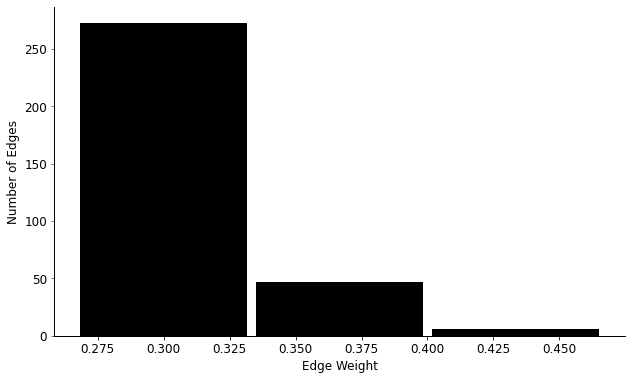

In [50]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(1, 1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])

#EDGE WEIGHTS
ax1.hist(edge_weight_array , bins = len(set(edge_weight_array)), color = 'black' , rwidth = 0.95 , edgecolor='white', linewidth=0.0, align='left')

ax1.set_ylabel('Number of Edges', fontsize = 12, color = 'k')
ax1.set_xlabel('Edge Weight' , fontsize = 12, color = 'k')

prettify_plot(ax1)
#ax1.set_yscale('log')
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(9, 5.5)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

In [51]:
edge_weight_thresholds = np.sort(np.array(list(set(edge_weight_array))))
edge_weight_thresholds

array([0.3, 0.4, 0.5])

In [52]:
def get_characteristics_of_subgraph(edge_weight_thresh):
    
    '''
    (1) This function returns the mean (edge weight) & (weighted degree) of the subgraph induced by the edges 
    that pass the edge weight threshold in the larger network.
    
    (2) Function returns the (# Edges) and (# Nodes) for these different subgraphs.
    '''
    
    #get the EDGE WEIGHTS for edges in the network that pass the edge weight threshold
    edge_weight_dict_subset = {key:value for key, value in edge_weight_dict.items() if value >= edge_weight_thresh}
    edge_weight_array_subset = np.array(list(edge_weight_dict_subset.values()))

    #get the SUBGRAPH induced by the most heavily weighted edges
    S = G.edge_subgraph(list(edge_weight_dict_subset.keys()))

    #Get a series of the WEIGHTED DEGREE for each node in the subgraph 
    node_list = [node_deg[0] for node_deg in list(S.degree(weight = 'weight'))]
    degree_list = [node_deg[1] for node_deg in list(S.degree(weight = 'weight'))]
    subgraph_weighted_degree_series = pd.Series(degree_list , index = node_list).sort_values(ascending = False)
    
    return [float(len(edge_weight_array_subset)), edge_weight_array_subset.mean(), float(len(node_list)), subgraph_weighted_degree_series.mean()]

#### Iterate through subnetworks of various sizes for different *edge weight thresholds* in original network

In [53]:
num_edges_for_subnetworks_list = []
mean_edge_weight_for_subnetworks_list = []
num_nodes_for_subnetworks_list = []
mean_weighted_deg_for_subnetworks_list = []

for edge_weight_thresh in edge_weight_thresholds:
    
    subgraph_num_edges , subgraph_mean_edge_weight , subgraph_num_nodes , subgraph_mean_weighted_deg = get_characteristics_of_subgraph(edge_weight_thresh)
    
    num_edges_for_subnetworks_list.append(subgraph_num_edges)
    mean_edge_weight_for_subnetworks_list.append(subgraph_mean_edge_weight)
    num_nodes_for_subnetworks_list.append(subgraph_num_nodes)
    mean_weighted_deg_for_subnetworks_list.append(subgraph_mean_weighted_deg)
    
    print(edge_weight_thresh)
    
#convert to arrays
num_edges_for_subnetworks = np.array(num_edges_for_subnetworks_list)
mean_edge_weight_for_subnetworks = np.array(mean_edge_weight_for_subnetworks_list)
num_nodes_for_subnetworks = np.array(num_nodes_for_subnetworks_list)
mean_weighted_deg_for_subnetworks = np.array(mean_weighted_deg_for_subnetworks_list)

0.3
0.4
0.5


#### Plot various characteristics of subgraphs induced by highest weighted edges

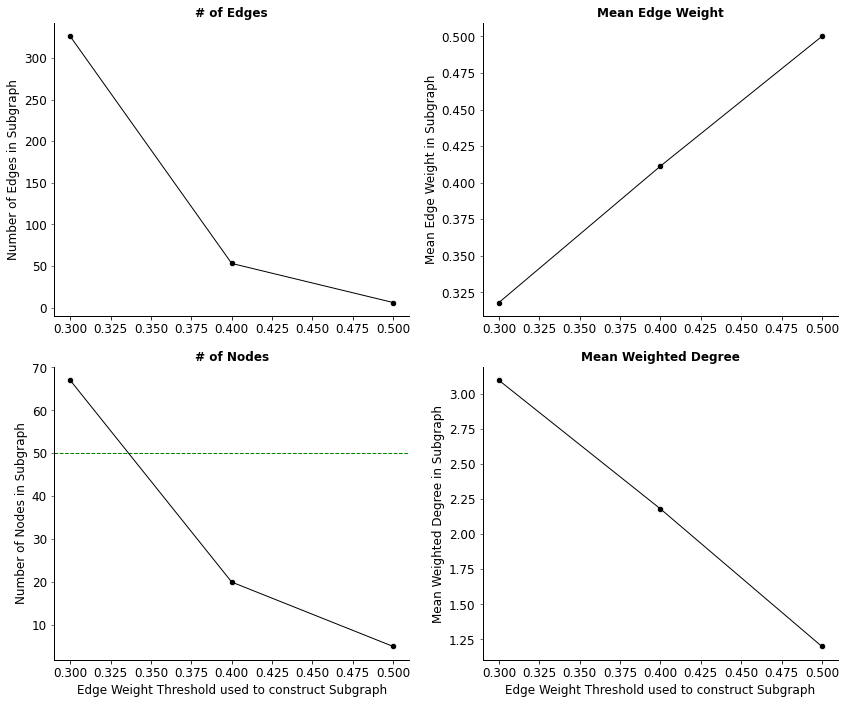

In [55]:
fig = plt.figure(constrained_layout=True)

gs = GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])

#NUMBER OF EDGES
ax1.scatter(edge_weight_thresholds, num_edges_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 40 , alpha = 1.0)
ax1.plot(edge_weight_thresholds, num_edges_for_subnetworks , color = 'black' , linewidth=1.0)

ax1.set_ylabel('Number of Edges in Subgraph', fontsize = 12, color = 'k')
ax1.set_title('# of Edges', fontsize = 12, color = 'k' , weight = 'bold')

prettify_plot(ax1)

#EDGE WEIGHT
ax2.scatter(edge_weight_thresholds, mean_edge_weight_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 40 , alpha = 1.0)
ax2.plot(edge_weight_thresholds, mean_edge_weight_for_subnetworks , color = 'black' , linewidth=1.0)

ax2.set_ylabel('Mean Edge Weight in Subgraph', fontsize = 12, color = 'k')
ax2.set_title('Mean Edge Weight', fontsize = 12, color = 'k' , weight = 'bold')

prettify_plot(ax2)

#NUMBER OF NODES

#targeting sub-networks with around ~50-500 nodes
## ax3.axhline(y = 500, linewidth = 1.0, color = 'green', linestyle = '--')
ax3.axhline(y = 50, linewidth = 1.0, color = 'green', linestyle = '--')

ax3.scatter(edge_weight_thresholds, num_nodes_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 40 , alpha = 1.0)
ax3.plot(edge_weight_thresholds, num_nodes_for_subnetworks , color = 'black' , linewidth=1.0)

ax3.set_ylabel('Number of Nodes in Subgraph', fontsize = 12, color = 'k')
ax3.set_xlabel('Edge Weight Threshold used to construct Subgraph' , fontsize = 12, color = 'k')
ax3.set_title('# of Nodes', fontsize = 12, color = 'k' , weight = 'bold')

prettify_plot(ax3)
    
#WEIGHTED DEGREE
ax4.scatter(edge_weight_thresholds, mean_weighted_deg_for_subnetworks , color = 'black' , linewidth=0.75 , edgecolor = 'white' , s = 40 , alpha = 1.0)
ax4.plot(edge_weight_thresholds, mean_weighted_deg_for_subnetworks , color = 'black' , linewidth=1.0)

ax4.set_ylabel('Mean Weighted Degree in Subgraph', fontsize = 12, color = 'k')
ax4.set_xlabel('Edge Weight Threshold used to construct Subgraph' , fontsize = 12, color = 'k')
ax4.set_title('Mean Weighted Degree', fontsize = 12, color = 'k' , weight = 'bold')

prettify_plot(ax4)
    
################### Plot ###################
fig = plt.gcf()
fig.set_size_inches(12, 10)
fig.tight_layout()

#file_name = '/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/Figures/lab_meeting_12_12_19/pairwise_SNP_distance/distribution_of_pairwise_SNP_distances.png'
#plt.savefig(file_name, bbox_inches='tight', dpi = 300 , transparent = True)

plt.show()

How does the **edge weight threshold** affect the **number of nodes** in the subnetwork?

In [56]:
for edge_weight_thresh_i, num_nodes_subnetwork_i in zip(edge_weight_thresholds, num_nodes_for_subnetworks):
    print(f'Edge Weight Threshold = {edge_weight_thresh_i} , Number of Nodes in Subnetwork = {num_nodes_subnetwork_i}')

Edge Weight Threshold = 0.3 , Number of Nodes in Subnetwork = 67.0
Edge Weight Threshold = 0.4 , Number of Nodes in Subnetwork = 20.0
Edge Weight Threshold = 0.5 , Number of Nodes in Subnetwork = 5.0


We're aiming to run enrichment analysis on **~50-500 nodes** so we have to adjust the edge-weight thresholds for this.

In [57]:
print(edge_weight_thresholds)

[0.3 0.4 0.5]


## [4] Iterate through subnetworks constructed from most heavily weighted edges and preform gene enrichment analysis

### *Function* to plot subnetworks (after thresholding edge weights) & perform gene enrichment on nodes

In [76]:
def subgraph_visualize_and_gene_enrichment(edge_weight_thresh, gene_set_category):
    
    '''
    (1) This function returns visualizes the sub-network generated by 
    retaining only the edge weights above the input edge weight threshold.
        (1.1) colors nodes by weighted degree
        (1.2) colors nodes by mean logFC
        
    (2) This function also returns a dataframe from the gene enrichment 
    analysis run on the nodes of the subnetwork.
    '''
    
    #get the EDGE WEIGHTS for edges in the network that pass the edge weight threshold
    edge_weight_dict_subset = {key:value for key, value in edge_weight_dict.items() if value >= edge_weight_thresh}
    edge_weight_array_subset = np.array(list(edge_weight_dict_subset.values()))

    #get the SUBGRAPH induced by the most heavily weighted edges
    S = G.edge_subgraph(list(edge_weight_dict_subset.keys()))
    
    #print some stats
    print('')
    print('')
    print('')
    print('')
    print(f'Edge Weight Threshold = {edge_weight_thresh}')
    print(f'Number of Nodes = {len(S.nodes)}')
    print('---------------------------------------------')
    
    #visualize subgraph
    pos = nx.spring_layout(S , weight = 'weight' , iterations = 350 , k = 1.65)
    visualize_network_color_by_weighted_deg_and_logFC(S, pos)
    
    #gene set enrichment
    gene_enrichr_df = run_enrichr_on_list_of_genes(list(S.nodes), gene_set_category)
    print(f'gene enrichment for nodes in this network: ')
    display(gene_enrichr_df.head(n=40)) #return the top 40 hits if there are > 40
    print('---------------------------------------------')
    
    ## return gene_enrichr_df

### Iterate through subnetworks of various sizes for different *edge weight thresholds* in original network

We're going to start with the smallest **edge weight threshold** and iterate down from there (increase edge weight threshold but decrease # of nodes) to preform gene enrichment

## [4.1] *Immune* Gene Sets

################################################################################################################################################################################################





Edge Weight Threshold = 0.3
Number of Nodes = 67
---------------------------------------------


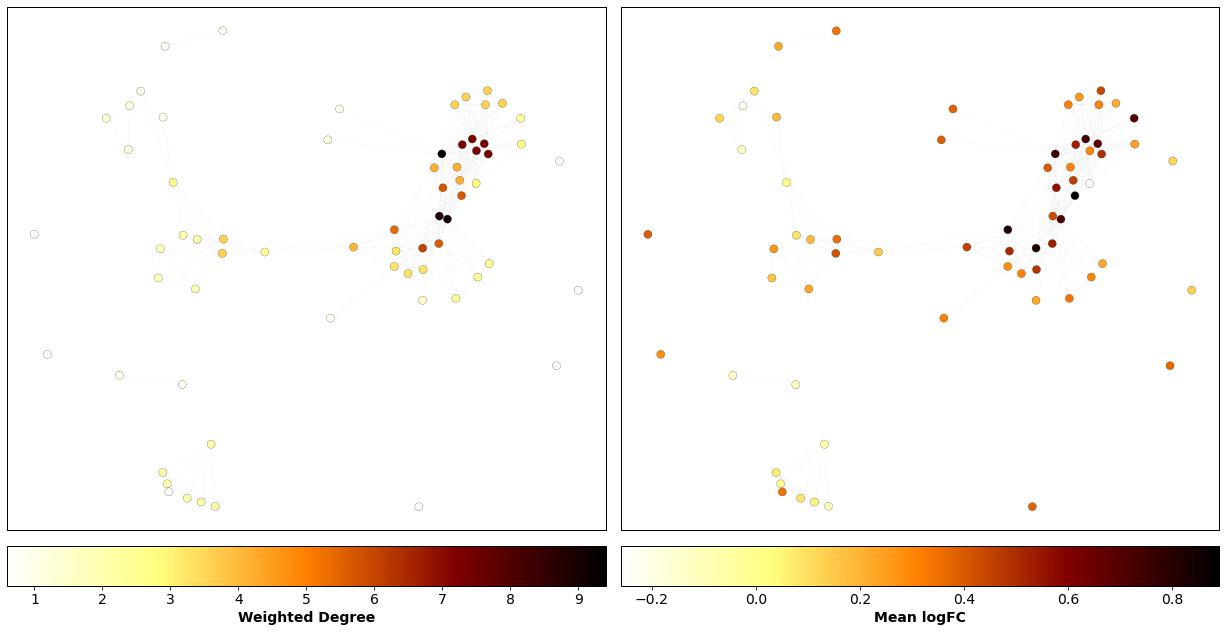

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,DC.M3.4,2.260747e-23,1.220803e-21,14/53,GBP1;LAP3;SCO2;SEPT4;PARP9;IFIT2;GBP4;SAMD9L;C...,Interferon,DC.M3,0.435381
1,DC.M4.2,5.150442e-12,1.390619e-10,8/48,MGAM;S100A12;TLR5;FCAR;ANXA3;CASP5;GPR141;SAMSN1,Inflammation,DC.M4,0.113772
2,DC.M1.2,4.215716e-10,7.588288e-09,6/27,IFIT3;XAF1;IFITM3;IFI44L;BATF2;SERPING1,Interferon,DC.M1,0.492877
3,LI.M16,1.266101e-08,1.709237e-07,6/46,MGAM;FCGR1A;FCGR1B;FCAR;TLR5;TLR1,TLR and inflammatory signaling,immune,0.344067
4,LI.S4,9.645470e-07,1.041711e-05,6/94,MGAM;FCGR1B;TLR5;FCAR;TLR1;CCR1,Monocyte surface signature,immune,0.273047
5,LI.M37.0,3.370970e-06,3.033873e-05,9/347,NLRC4;MGAM;TLR5;CEACAM1;FCAR;TLR1;CLEC5A;CD3G;...,immune activation - generic cluster,immune,0.171077
6,LI.M165,6.752044e-06,5.208720e-05,4/35,PARP9;IFIT3;SERPING1;IFIT2,enriched in activated dendritic cells (II),immune,0.402732
7,LI.M11.0,5.332726e-05,3.599590e-04,6/189,S100A12;FCGR1B;FCGR1A;FCAR;TLR5;CCR1,enriched in monocytes (II),immune,0.307827
8,LI.M75,6.112869e-05,3.667721e-04,3/22,C1QB;SERPING1;ANXA3,antiviral IFN signature,immune,0.549688


---------------------------------------------




Edge Weight Threshold = 0.4
Number of Nodes = 20
---------------------------------------------


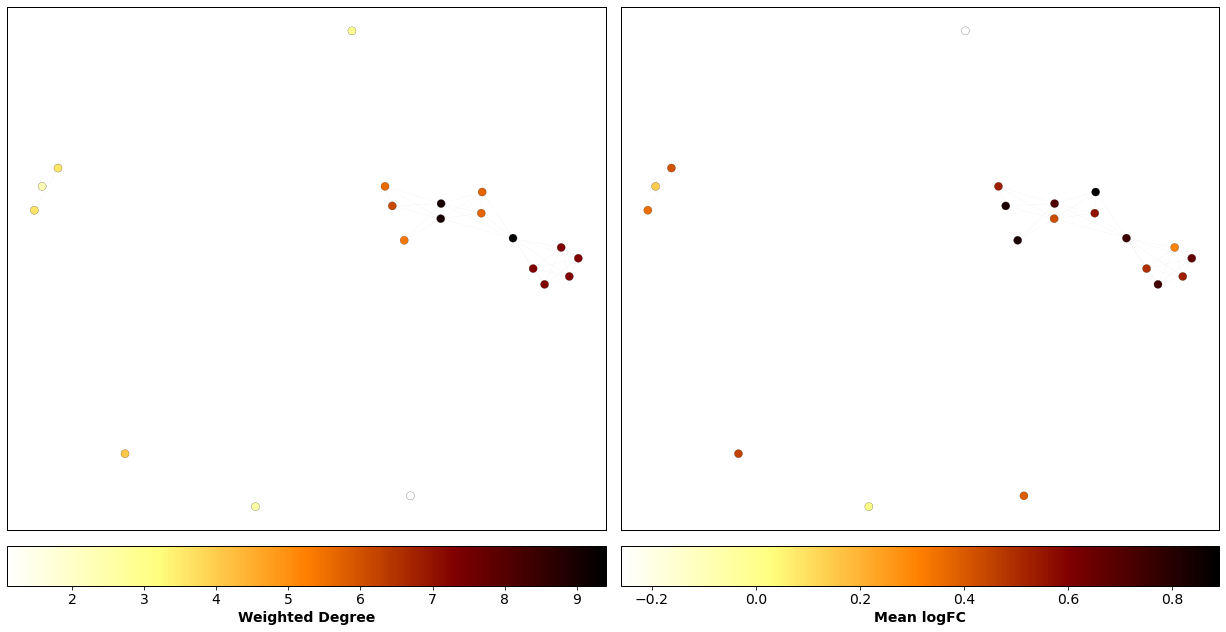

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,DC.M3.4,1.306058e-11,2.873327e-10,6/53,GBP1;SEPT4;GBP4;AIM2;GBP5;WARS,Interferon,DC.M3,0.570418
1,LI.M16,1.461561e-05,1.607717e-04,3/46,FCGR1A;FCGR1B;TLR5,TLR and inflammatory signaling,immune,0.470727


---------------------------------------------




Edge Weight Threshold = 0.5
Number of Nodes = 5
---------------------------------------------


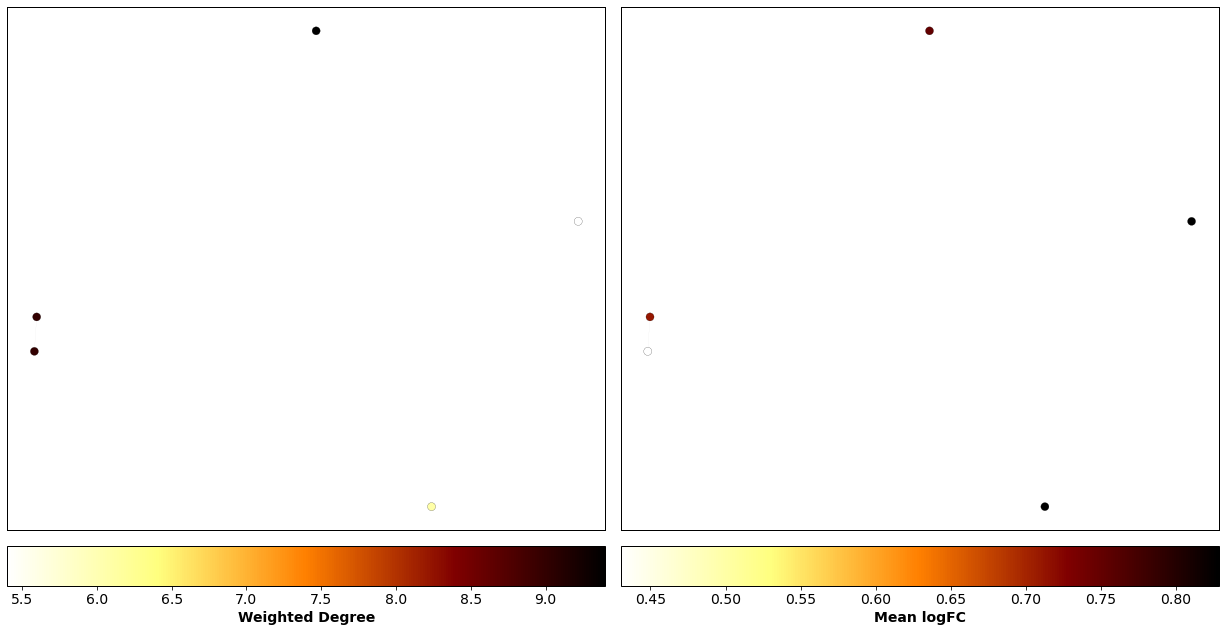

gene enrichment for nodes in this network: 


,P-value,Adjusted P-value,Overlap,Genes,ID,Title,Category,logFC


---------------------------------------------


In [77]:
for edge_weight_thresh in edge_weight_thresholds:
    
    subgraph_visualize_and_gene_enrichment(edge_weight_thresh, 'IMMUNE')

## [4.2] *Reactome* Gene Sets

################################################################################################################################################################################################





Edge Weight Threshold = 0.3
Number of Nodes = 67
---------------------------------------------


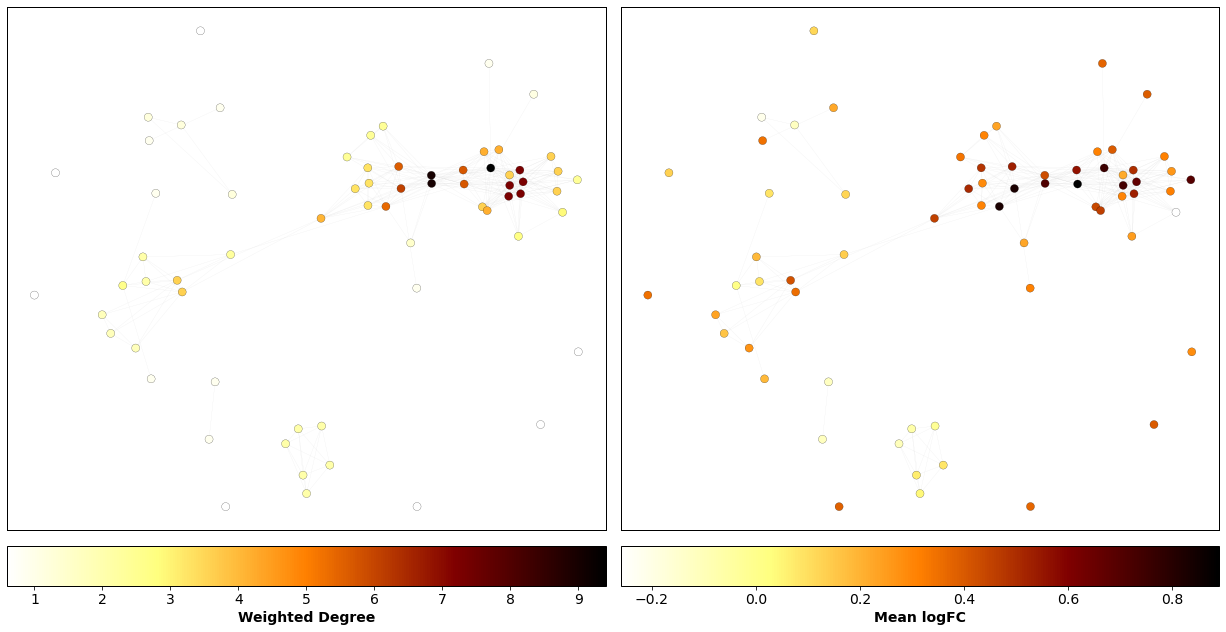

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,M983,2.043364e-10,2.452036e-08,10/159,IFIT3;GBP1;XAF1;IFITM3;IFIT2;GBP4;FCGR1B;FCGR1...,Reactome interferon signaling,C2:CP:REACTOME,0.453237
1,M1045,2.170439e-09,1.302264e-07,18/933,IFIT3;GBP1;XAF1;IFITM3;C1QB;NLRC4;IFIT2;GBP4;F...,Reactome immune system,C2:CP:REACTOME,0.370526
2,M1060,3.389321e-08,1.355728e-06,10/270,IFIT3;GBP1;XAF1;IFITM3;IFIT2;GBP4;FCGR1B;FCGR1...,Reactome cytokine signaling in immune system,C2:CP:REACTOME,0.453237
3,M965,8.764790e-08,2.629437e-06,6/63,GBP1;GBP4;FCGR1B;FCGR1A;HLA-DRB3;GBP5,Reactome interferon gamma signaling,C2:CP:REACTOME,0.536131


---------------------------------------------




Edge Weight Threshold = 0.4
Number of Nodes = 20
---------------------------------------------


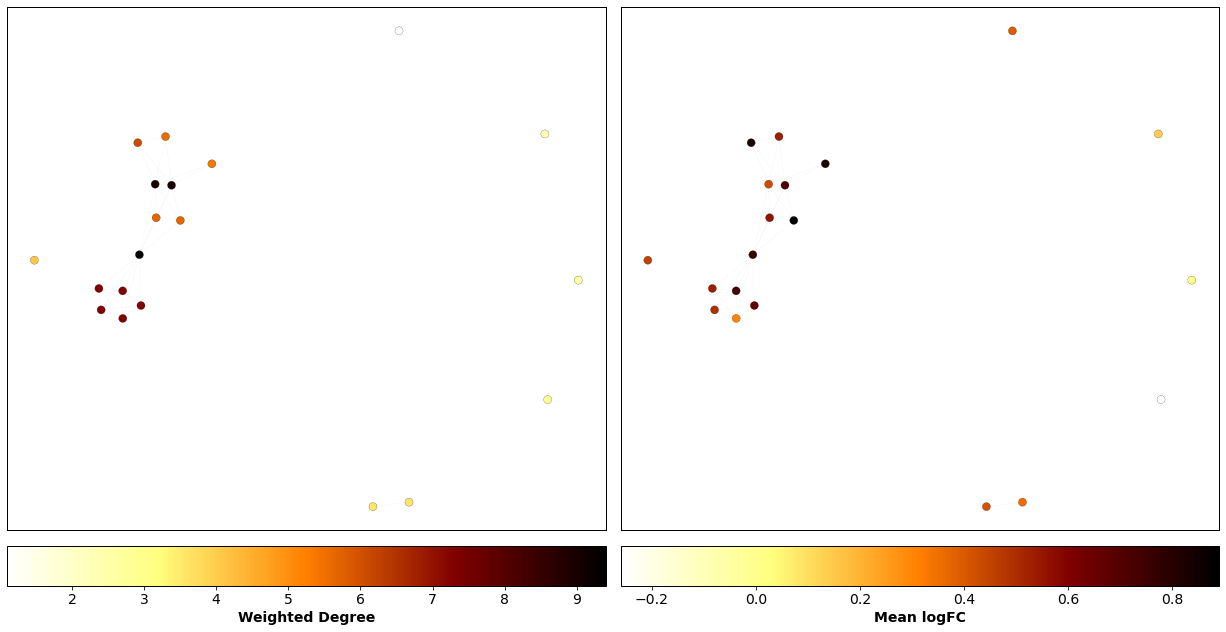

gene enrichment for nodes in this network: 


,ID,P-value,Adjusted P-value,Overlap,Genes,Title,Category,logFC
0,M965,5.031879e-09,1.610201e-07,5/63,GBP1;GBP4;FCGR1B;FCGR1A;GBP5,Reactome interferon gamma signaling,C2:CP:REACTOME,0.593432
1,M983,5.340887e-07,8.545419e-06,5/159,GBP1;GBP4;FCGR1B;FCGR1A;GBP5,Reactome interferon signaling,C2:CP:REACTOME,0.593432
2,M1045,2.398365e-06,2.558255e-05,8/933,GBP1;C1QB;GBP4;FCGR1A;TLR5;FCGR1B;AIM2;GBP5,Reactome immune system,C2:CP:REACTOME,0.558590
3,M1060,7.194653e-06,5.755723e-05,5/270,GBP1;GBP4;FCGR1B;FCGR1A;GBP5,Reactome cytokine signaling in immune system,C2:CP:REACTOME,0.593432


---------------------------------------------




Edge Weight Threshold = 0.5
Number of Nodes = 5
---------------------------------------------


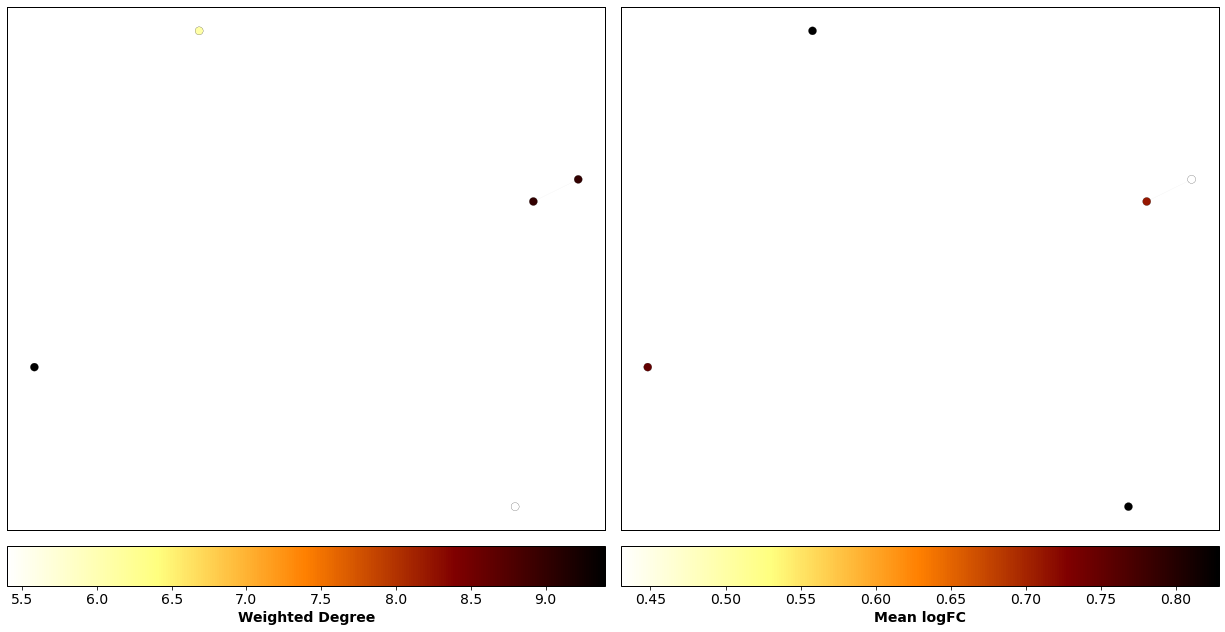

gene enrichment for nodes in this network: 


,P-value,Adjusted P-value,Overlap,Genes,ID,Title,Category,logFC


---------------------------------------------


In [78]:
for edge_weight_thresh in edge_weight_thresholds:
    
    subgraph_visualize_and_gene_enrichment(edge_weight_thresh, 'REACTOME')